In [2]:
import torch
from pprint import pprint, pformat
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
import copy
import torch.optim as optim

In [3]:
class AND(nn.Module):
    def __init__(self, input_count):
        super(AND, self).__init__()
        assert(input_count >= 2)
        self.linear = nn.Linear(input_count, 2)
        
    def forward(self, x):
        return F.log_softmax(self.linear(x))

In [ ]:
from itertools import product

def and_gate(*inputs):
    for i in inputs:
        if i == 0: return 0
    else: return 1
    
def truth_table_for_and(size=2):
    table = []
    for sample in product([0, 1], repeat=size):
        table.append([list(sample), and_gate(*sample)])
    return table   

pprint(truth_table_for_and(2))

In [5]:
and2 = AND(2)
truth_table2 = truth_table_for_and(2)
def train(epochs, print_every=1000):
    optimizer = optim.SGD(and2.parameters(), lr=0.1, momentum=0.01)
        
    losses = []
    weights = torch.Tensor()
    biases = torch.Tensor()
        
    weights = torch.cat([weights, and2.linear.weight.data.view(-1)])
    biases  = torch.cat([biases, and2.linear.bias.data.view(-1)])
    
    for epoch in range(epochs):
        for i, o in truth_table2:
            i , o = Variable(torch.Tensor([i])), Variable(torch.LongTensor([o]))
            o_ = and2(i)
            
            optimizer.zero_grad()
            loss = F.nll_loss(o_, o)
            loss.backward()
            optimizer.step()
                    
        if epoch % print_every == 0:
            weights = torch.cat([weights, and2.linear.weight.data.view(-1)])
            biases  = torch.cat([biases, and2.linear.bias.data.view(-1)])
            losses.append(loss.data[0])
            print('loss: {}'.format(loss.data[0]))
    
    weights = torch.cat([weights, and2.linear.weight.data.view(-1)])
    biases  = torch.cat([biases, and2.linear.bias.data.view(-1)])
    losses.append(loss.data[0])        
    
    return weights, biases, losses

In [10]:
weights, biases, losses = train(10000)
torch.save(and2.state_dict(), 'and_gate2.pth')

loss: 0.00564180314540863
loss: 0.0048542027361691
loss: 0.004259299952536821
loss: 0.00379424006678164
loss: 0.003419899847358465
loss: 0.0031137994956225157
loss: 0.0028573002200573683
loss: 0.0026390107814222574
loss: 0.0024534964468330145
loss: 0.0022920165210962296


torch.Size([4, 12]) torch.Size([2, 12]) 11

-6.0035 -5.9211
 6.6179  6.7002
[torch.FloatTensor of size 2x2]


 9.9746
-9.1252
[torch.FloatTensor of size 2]

torch.Size([12, 4]) torch.Size([12, 2]) 11
4 2 11


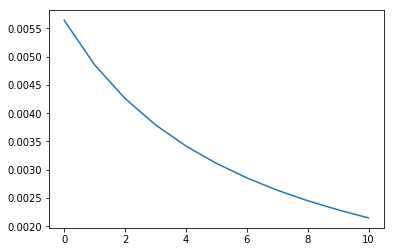

=========biases=========


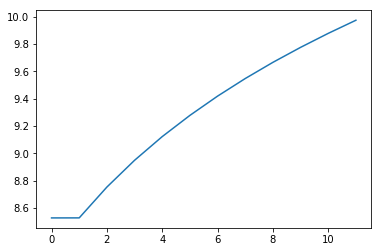

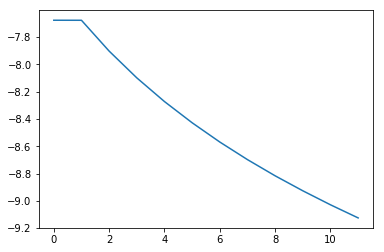

=========weights=========


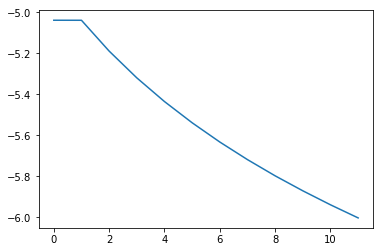

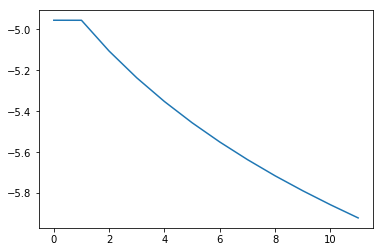

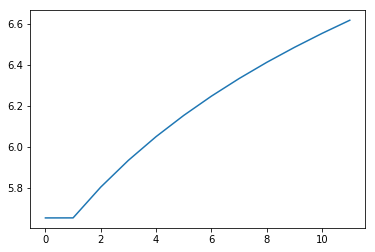

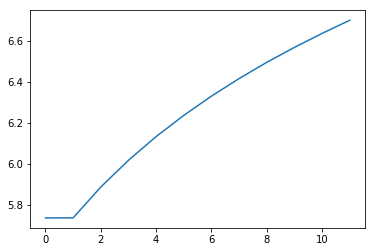

In [12]:
print(weights.size(), biases.size(), len(losses))
print(and2.linear.weight.data)
print(and2.linear.bias.data)

weights = weights.view(-1, 4)
biases = biases.view(-1, 2)

print(weights.size(), biases.size(), len(losses))
print(len(weights[0].tolist()), len(biases[0].tolist()), len(losses))

import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(range(len(losses)), losses)
plt.show()

print('=========biases=========')
for i in range(2):
    plt.plot(range(len(biases[:, i].tolist())),biases[:,i].tolist())
    plt.show()

print('=========weights=========')
for i in range(4):
    plt.plot(range(len(weights[:, i].tolist())),weights[:,i].tolist())
    plt.show()       

In [13]:
t = torch.Tensor()
for i in range(4):
    t = torch.cat([t, i * torch.ones([2, 2]).view(-1)])
    
print(t)
print(t.view(-1, 4))


 0
 0
 0
 0
 1
 1
 1
 1
 2
 2
 2
 2
 3
 3
 3
 3
[torch.FloatTensor of size 16]


 0  0  0  0
 1  1  1  1
 2  2  2  2
 3  3  3  3
[torch.FloatTensor of size 4x4]



In [14]:
#Looking closely

#output of neuron one
trained_weight = and2.linear.weight.data
trained_bias   = and2.linear.bias.data
#o1 = trained_weight[0,0] * x + trained_weight[1,0] * y
#o2 = trained_weight[0,1] * x + trained_weight[1,1] * y

for data, target in truth_table2:
    x, y = data
    o1 = trained_weight[0,0] * x + trained_weight[1,0] * y
    o2 = trained_weight[0,1] * x + trained_weight[1,1] * y
    print(o1, o2)
    
    print(F.log_softmax(Variable(torch.Tensor([o1, o2]))))

0.0 0.0
Variable containing:
-0.6931
-0.6931
[torch.FloatTensor of size 2]

6.6178507804870605 6.700157165527344
Variable containing:
-0.7351
-0.6528
[torch.FloatTensor of size 2]

-6.003494739532471 -5.921146869659424
Variable containing:
-0.7352
-0.6528
[torch.FloatTensor of size 2]

0.6143560409545898 0.7790102958679199
Variable containing:
-0.7789
-0.6142
[torch.FloatTensor of size 2]



In [17]:
def test():
    and2.eval()
    test_loss = 0
    correct = 0
    for data, target in truth_table2:
        
        data, target = Variable(torch.Tensor([data]), volatile=True), Variable(torch.LongTensor([target]))
        output = and2(data)
        loss = F.nll_loss(output, target)
        test_loss += loss.data[0]
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

    test_loss = test_loss
    test_loss /= len(truth_table2) # loss function already averages over batch size
    print('test loss: {}, correct pred: {}'.format(test_loss, correct))

In [18]:
test()

test loss: 0.0013041033396556934, correct pred: 4
